In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from xgboost import XGBClassifier

In [2]:
def make_dataset(file, k=-1):
	data = pd.read_csv(file)
	X = data.iloc[:, :-1].values
	y = data.iloc[:, -1].values

	X = StandardScaler().fit_transform(X)
	y = LabelEncoder().fit_transform(y)

	if k != -1:
		X = SelectKBest(f_classif, k=k).fit_transform(X, y)

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

	X_train = torch.FloatTensor(X_train)
	X_test = torch.FloatTensor(X_test)
	y_train = torch.FloatTensor(y_train)
	y_test = torch.FloatTensor(y_test)

	return X_train, X_test, y_train, y_test

In [3]:
# Define a simple neural network model
class TabularModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [4]:
def model_train(model, X_train, y_train, loss_fn, optimizer, n_epochs=250):
    acc = []
    model.train()
    
    for epoch in range(n_epochs):
        y_pred = model(X_train).squeeze()
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc.append((y_pred.round() == y_train).float().mean())

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}, Accuracy: {acc[-1]:.4f}")
        
    return acc
# model.eval()
# y_pred = model(X_val).squeeze()
# val_acc = (y_pred.round() == y_val).float().mean()
# val_acc = float(val_acc)
# print(f"Validation Accuracy: {acc:.4f}")

In [5]:
# X_train, X_test, y_train, y_test = make_dataset("clf_cat/default-of-credit-card-clients.csv")
X_train, X_test, y_train, y_test = make_dataset("clf_cat/road-safety.csv")


# Define the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
num_classes = 1

model = TabularModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
acc = model_train(model, X_train, y_train, criterion, optimizer, n_epochs=1000)

Epoch 1/1000, Loss: 509489.4375, Accuracy: 0.4930
Epoch 2/1000, Loss: 509018.4375, Accuracy: 0.5446
Epoch 3/1000, Loss: 508609.5625, Accuracy: 0.5879
Epoch 4/1000, Loss: 508243.6250, Accuracy: 0.6123
Epoch 5/1000, Loss: 507905.5625, Accuracy: 0.6278
Epoch 6/1000, Loss: 507584.3438, Accuracy: 0.6392
Epoch 7/1000, Loss: 507273.4688, Accuracy: 0.6498
Epoch 8/1000, Loss: 506971.2500, Accuracy: 0.6610
Epoch 9/1000, Loss: 506679.2500, Accuracy: 0.6698
Epoch 10/1000, Loss: 506399.9375, Accuracy: 0.6785
Epoch 11/1000, Loss: 506135.1875, Accuracy: 0.6850
Epoch 12/1000, Loss: 505886.5625, Accuracy: 0.6917
Epoch 13/1000, Loss: 505653.7500, Accuracy: 0.6967
Epoch 14/1000, Loss: 505438.0625, Accuracy: 0.7021
Epoch 15/1000, Loss: 505243.3750, Accuracy: 0.7062
Epoch 16/1000, Loss: 505073.3125, Accuracy: 0.7095
Epoch 17/1000, Loss: 504929.5000, Accuracy: 0.7115
Epoch 18/1000, Loss: 504810.0312, Accuracy: 0.7131
Epoch 19/1000, Loss: 504709.8125, Accuracy: 0.7145
Epoch 20/1000, Loss: 504624.0625, Accura

In [7]:
def plot_all_accuracy(acc, save_path=None):
	for key, value in acc.items():
		plt.plot(range(len(value)), value, label=key)
	plt.legend()
	plt.title("Training Accuracy")
	plt.xlabel("Epoch")
	plt.ylabel("Accuracy")
	if save_path:
		plt.savefig(save_path)
	plt.show()

In [8]:
eval_set = [(X_test, y_test)]
eval_metric = ["auc"]

model = XGBClassifier(objective='binary:logistic', n_estimators=1000, learning_rate=0.01, eval_metric=eval_metric)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results = model.evals_result()

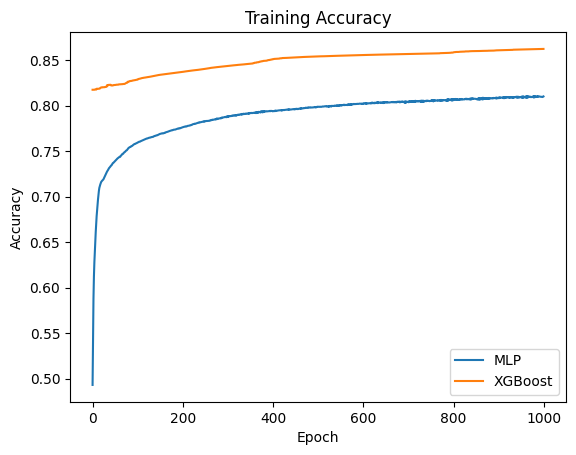

In [9]:
plot_all_accuracy({"MLP": acc, "XGBoost": results['validation_0']['auc']})

In [53]:
sel_X_train, sel_X_test, sel_y_train, sel_y_test = make_dataset("clf_cat/electricity.csv", k=100)

ValueError: k should be <= n_features = 8; got 100. Use k='all' to return all features.

In [50]:
# Define the model, loss function, and optimizer
input_size = sel_X_train.shape[1]
hidden_size = 64
num_classes = 1

sel_model = TabularModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sel_model.parameters(), lr=0.01)

acc = model_train(sel_model, sel_X_train, sel_y_train, criterion, optimizer, n_epochs=1000)

Epoch 1/1000, Loss: 509396.8750, Accuracy: 0.5035
Epoch 2/1000, Loss: 508930.8750, Accuracy: 0.5954
Epoch 3/1000, Loss: 508537.0625, Accuracy: 0.6213
Epoch 4/1000, Loss: 508187.3750, Accuracy: 0.6275
Epoch 5/1000, Loss: 507863.4375, Accuracy: 0.6343
Epoch 6/1000, Loss: 507553.1250, Accuracy: 0.6417
Epoch 7/1000, Loss: 507247.6250, Accuracy: 0.6507
Epoch 8/1000, Loss: 506943.5000, Accuracy: 0.6606
Epoch 9/1000, Loss: 506643.3750, Accuracy: 0.6713
Epoch 10/1000, Loss: 506354.1562, Accuracy: 0.6809
Epoch 11/1000, Loss: 506085.0625, Accuracy: 0.6885
Epoch 12/1000, Loss: 505840.4062, Accuracy: 0.6945
Epoch 13/1000, Loss: 505616.3438, Accuracy: 0.6984
Epoch 14/1000, Loss: 505406.6562, Accuracy: 0.7026
Epoch 15/1000, Loss: 505211.5625, Accuracy: 0.7072
Epoch 16/1000, Loss: 505038.0938, Accuracy: 0.7102
Epoch 17/1000, Loss: 504892.9375, Accuracy: 0.7132
Epoch 18/1000, Loss: 504775.8125, Accuracy: 0.7145
Epoch 19/1000, Loss: 504679.5625, Accuracy: 0.7156
Epoch 20/1000, Loss: 504596.7500, Accura

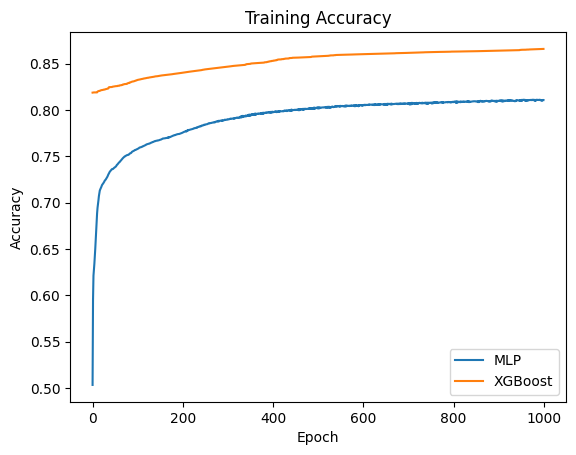

In [51]:
eval_set = [(sel_X_test, sel_y_test)]
eval_metric = ["auc"]

model = XGBClassifier(objective='binary:logistic', n_estimators=1000, learning_rate=0.01, eval_metric=eval_metric)
model.fit(sel_X_train, sel_y_train, eval_set=eval_set, verbose=False)
results = model.evals_result()

plot_all_accuracy({"MLP": acc, "XGBoost": results['validation_0']['auc']}, "img/road_20.png")